In [1]:
import numpy as np
import torch
import torch.nn as nn
from core import VAE,RBFNN,VAE_RBF,utils,manifolds,geodesics
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, transforms
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
from mpl_toolkits.mplot3d import Axes3D

# Download and preprocess data

In [21]:
# MNIST Dataset transformation
fashionmnist_transform = transforms.Compose([
    transforms.ToTensor(), # Converts to [0, 1] interval
    transforms.Lambda(lambda x: torch.flatten(x)) # Flattens the image to a 1D vector
])

# dataset class to efficiently extract the relevant labels and not make a copy of the entire dataset
class FilteredMNIST(Dataset):
    def __init__(self, mnist_dataset, labels):
        # Extract only the data with the specified labels
        self.data = [(img, label) for img, label in mnist_dataset if label in labels]
        self.imgs = [img for img, label in self.data]
        self.targets = [label for img, label in self.data]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


# Download and load the MNIST dataset (if taking too long, cancel and try again it will worky)
full_train_dataset = datasets.FashionMNIST(root='fashionmnist_data', train=True, transform=fashionmnist_transform, download=True)
print("Original size of the dataset: ", len(full_train_dataset))
filtered_labels = [0,1,7,8,4]
print("Filtered labels: ", filtered_labels)
train_dataset = FilteredMNIST(full_train_dataset, filtered_labels)
print("New size of the dataset: ", len(train_dataset))

batch_size = 256
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True,num_workers=4)

Original size of the dataset:  60000
Filtered labels:  [0, 1, 7, 8, 4]
New size of the dataset:  30000


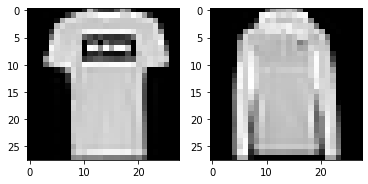

In [26]:
# show examples
fig,axs = plt.subplots(1,2)
axs[0].imshow(train_dataset[0][0].reshape(28, 28),cmap='gray')
axs[1].imshow(train_dataset[12][0].reshape(28, 28),cmap='gray')

# Train VAE RBFNN Model

## Initilize the VAE model

In [42]:
# model
input_dim = train_dataset[0][0].shape[-1]  # The dimension of the data
hidden_dims = [128, 64, 32]  # The dimension of the hidden layers
latent_dim = 2  # The latent space dimension
hidden_activation = nn.Tanh()  # The activation function of the hidden layers
encoder_output_mu_activation = nn.Identity() # Activation of the output of mu by the encoder
encoder_output_logvar_activation = nn.Softplus() # Activation of the output of logvar by the encoder
decoder_output_mu_activation = nn.Sigmoid() # Activation of the output of mu by the decoder
decoder_output_logvar_activation = nn.Softplus() # Activation of the output of logvar by the decoder

# optimizer
#lambda_reg = 1e-7 # weight decay (l2 regulariztaion to the losss)
learning_rate = 1e-5 #1e-3

# training
epochs = 800
warmup = int(0.33 * epochs)
batch_size = 128 #128

In [43]:
# initilize model
model = VAE.VAE(input_dim, 
                hidden_dims, 
                latent_dim, 
                hidden_activation, 
                encoder_output_mu_activation,
                encoder_output_logvar_activation,
                decoder_output_mu_activation,
                decoder_output_logvar_activation)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

VAE(
  (encoder): VAE_encoder(
    (layers): Sequential(
      (0): Linear(in_features=784, out_features=128, bias=True)
      (1): Tanh()
      (2): Linear(in_features=128, out_features=64, bias=True)
      (3): Tanh()
      (4): Linear(in_features=64, out_features=32, bias=True)
      (5): Tanh()
    )
    (output_mu): Sequential(
      (0): Linear(in_features=32, out_features=2, bias=True)
      (1): Identity()
    )
    (output_logvar): Sequential(
      (0): Linear(in_features=32, out_features=2, bias=True)
      (1): Softplus(beta=1, threshold=20)
    )
  )
  (decoder): VAE_decoder(
    (layers): Sequential(
      (0): Linear(in_features=2, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=64, bias=True)
      (3): Tanh()
      (4): Linear(in_features=64, out_features=128, bias=True)
      (5): Tanh()
    )
    (output_mu): Sequential(
      (0): Linear(in_features=128, out_features=784, bias=True)
      (1): Sigmoid()
    )
    (output_

## Training of the VAE

[Epoch: 0/800] [objective loss: 303.640]
[Epoch: 20/800] [objective loss: 59.582]
[Epoch: 40/800] [objective loss: 40.509]
[Epoch: 60/800] [objective loss: 36.931]
[Epoch: 80/800] [objective loss: 35.968]
[Epoch: 100/800] [objective loss: 35.290]
[Epoch: 120/800] [objective loss: 34.663]
[Epoch: 140/800] [objective loss: 34.192]
[Epoch: 160/800] [objective loss: 32.024]
[Epoch: 180/800] [objective loss: 28.908]
[Epoch: 200/800] [objective loss: 28.806]
[Epoch: 220/800] [objective loss: 28.684]
[Epoch: 240/800] [objective loss: 28.237]
[Epoch: 260/800] [objective loss: 27.829]
[Epoch: 280/800] [objective loss: 26.900]
[Epoch: 300/800] [objective loss: 25.328]
[Epoch: 320/800] [objective loss: 24.578]
[Epoch: 340/800] [objective loss: 24.222]
[Epoch: 360/800] [objective loss: 24.014]
[Epoch: 380/800] [objective loss: 23.792]
[Epoch: 400/800] [objective loss: 23.632]
[Epoch: 420/800] [objective loss: 23.455]
[Epoch: 440/800] [objective loss: 23.256]
[Epoch: 460/800] [objective loss: 23.13

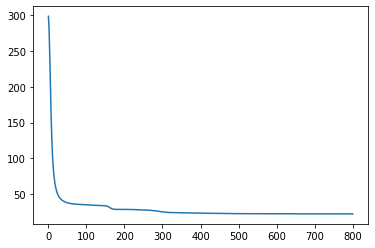

In [44]:
# Train the VAE with the new prior
ELBO_loss = []
for epoch in range(epochs):
    # Initialize the losses
    train_loss = 0.0

    for X_batch,y_batch in train_loader:
        # Forward pass
        MU_X_eval, LOG_VAR_X_eval, Z_ENC_eval, MU_Z_eval, LOG_VAR_Z_eval = model(X_batch)

        # Compute the regluarization parameter for the warmup
        # that forces the latent variables to follow the prior distribution
        # see the code of VAE_loss for more informations
        r = min(1.0, epoch / warmup) if warmup > 0 else 0.0 

        # The VAE loss
        loss = VAE.VAE_loss(x=X_batch, mu_x=MU_X_eval, log_var_x=LOG_VAR_X_eval,
                                        mu_z=MU_Z_eval, log_var_z=LOG_VAR_Z_eval, r=r)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Average loss for the epoch
    average_epoch_loss = train_loss / len(train_loader)
    ELBO_loss.append(average_epoch_loss)

    if epoch % 20 == 0:
        print(f"[Epoch: {epoch}/{epochs}] [objective loss: {average_epoch_loss:.3f}]")
    
ELBO_train = round(ELBO_loss[-1], 2)
print(f'[ELBO train: {ELBO_train}]')
print("Training finished")

plt.figure()
plt.plot(range(1, epochs), ELBO_loss[1:])
# plt.xlabel('Epochs')
# plt.ylabel('ELBO Loss')
plt.show()

### Encode and decode the whole dataset

We need this so we can train the rbf using these output without re-forwarding inputs into the model

In [45]:
# encode and decode the data and store the outputs of the model
# computed on the whole dataset
latent_means_list = []
latent_logvars_list = []
latent_z = []
output_means_list = []
output_logvars_list = []
labels_list = []

with torch.no_grad():  
    for imgs, labels_ in train_loader: 
        mu_x, log_var_x, z_enc, mu_z, log_var_z = model(imgs)
        z_rep = VAE.VAE.reparametrization_trick(mu_z, log_var_z)
        latent_means_list.append(mu_z)
        latent_logvars_list.append(log_var_z)
        latent_z.append(z_rep)
        output_means_list.append(mu_x)
        output_logvars_list.append(log_var_x)
        labels_list.append(labels_)

# Now we concatenate the list to form a single Tensor
latent_means = torch.cat(latent_means_list, dim=0)
latent_logvars = torch.cat(latent_logvars_list, dim=0)
latent_z = torch.cat(latent_z, dim=0)
output_means = torch.cat(output_means_list, dim=0)
output_logvars = torch.cat(output_logvars_list, dim=0)
labels = torch.cat(labels_list, dim=0)

## Sanity check of the VAE

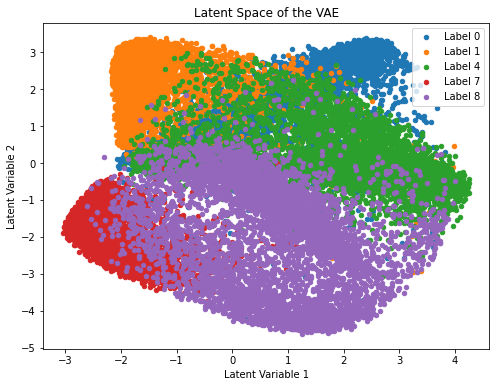

In [46]:
#%matplotlib widget # for 3d plot

# plot latent space
utils.plot_latent_space(latent_means,labels)

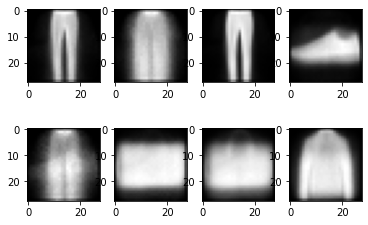

In [47]:
# display reconstructed output of the model
fig,axs = plt.subplots(2,4)
with torch.no_grad():
    for i in range(8):
        random_index = np.random.randint(0, len(train_dataset))
        pred = model(train_dataset[random_index][0].unsqueeze(0))[0] #just get mu_x
        axs[i//4,i%4].imshow(pred.reshape(28, 28),cmap='gray')

Text(0, 0.5, 'Latent Variable 2')

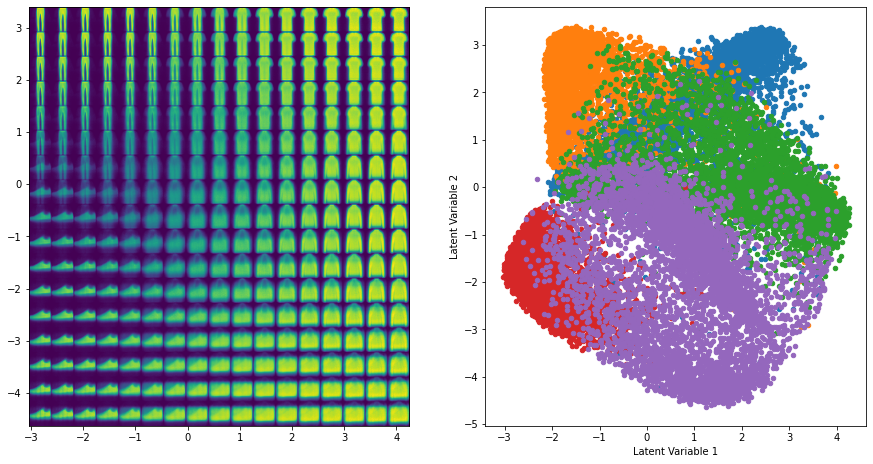

In [48]:
max_x = latent_means.max(dim=0).values[0]
max_y = latent_means.max(dim=0).values[1]
min_x = latent_means.min(dim=0).values[0]
min_y = latent_means.min(dim=0).values[1]
n=17
w = 28
img = np.zeros((n*w, n*w))
for i, y in enumerate(np.linspace(min_y,max_y, n)):
    for j, x in enumerate(np.linspace(min_x,max_x, n)):
        z = torch.Tensor([[x, y]])
        x_hat = model.decode(z)[0]
        x_hat = x_hat.reshape(28, 28).detach().numpy()
        img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat

plt.figure(figsize=(15, 15))
plt.subplot(121, aspect='equal')
plt.imshow(img, extent=[min_x,max_x, min_y,max_y])
ax=plt.subplot(122, aspect='equal')
for label in np.unique(labels):
    points = latent_means[labels == label]
    ax.scatter(points[:, 0], points[:, 1], s=20, label=f'Label {label}')
ax.set_xlabel('Latent Variable 1')
ax.set_ylabel('Latent Variable 2')

## Initialize the RBFN Model

### Create the RBF Network

Apply Kmeans to the latent space


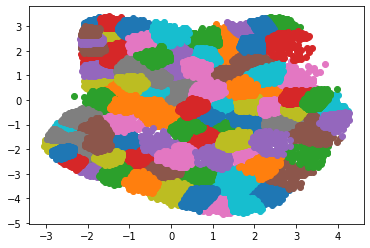

Compute the bandwidths for each centroids


In [65]:
# create RBF network
k_rbf = 96
a = 2
zeta_rbf = 1e-7
rbfnn = RBFNN.RBFNN(a=a,k_rbf=k_rbf,zeta_rbf=zeta_rbf,W_dim=input_dim,latent_dim=latent_dim)

# apply kmeans to the means of the latent space
print("Apply Kmeans to the latent space")
plt.figure()
centers_rbf,centers_ids = rbfnn.fit_kmeans(latent_means,display=True)
# compute the bandwidths for each centroids
print("Compute the bandwidths for each centroids")
lambdas_k = rbfnn.compute_bandwidth(latent_means)

## Train the RBF Network

[iter: 0/300] [objective loss: 3.484083]
[iter: 20/300] [objective loss: 0.675460]
[iter: 40/300] [objective loss: 0.317575]
[iter: 60/300] [objective loss: 0.259481]
[iter: 80/300] [objective loss: 0.250366]
[iter: 100/300] [objective loss: 0.248421]
[iter: 120/300] [objective loss: 0.247819]
[iter: 140/300] [objective loss: 0.247597]
[iter: 160/300] [objective loss: 0.247348]
[iter: 180/300] [objective loss: 0.247725]
[iter: 200/300] [objective loss: 0.247192]
[iter: 220/300] [objective loss: 0.247729]
[iter: 240/300] [objective loss: 0.247603]
[iter: 260/300] [objective loss: 0.247245]
[iter: 280/300] [objective loss: 0.247139]
[ELBO train: 0.247758]
Training finished


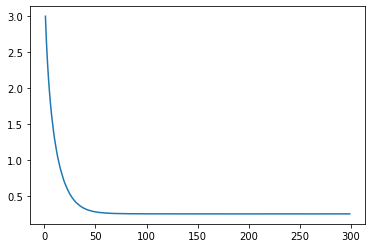

In [66]:
RBF_loss = []
nb_iters=300
optimizer_rbf = torch.optim.Adam(rbfnn.parameters(), lr=2e-4, weight_decay=1e-7)

for iter in range(nb_iters):
    # Initialize the losses
    train_loss = 0.0

    permutation = np.random.permutation(len(train_dataset))

    for i in range(0, len(train_dataset), batch_size):
        # Forward pass in the model
        indices = permutation[i:i + batch_size]
        # get previously computed latent means and logvars
        LOG_VAR_X = output_logvars[indices, :]
        MU_Z = latent_means[indices, :]
 
        # Regress the output of the variance network
        LOG_VAR_X_eval_RBF = -torch.log(rbfnn(MU_Z)) # = log(1/beta_psi(z)) to have logvar

        loss = torch.nn.MSELoss(reduction='mean')(LOG_VAR_X, LOG_VAR_X_eval_RBF)
             
        # Backward pass
        optimizer_rbf.zero_grad()
        loss.backward()
        optimizer_rbf.step()

        # Ensure positivity of the weights
        rbfnn.W_rbf.data.clamp_(min=1e-5)
        train_loss += loss.item()

    # Average loss for the iter
    average_iter_loss = train_loss / len(train_loader)
    RBF_loss.append(average_iter_loss)

    if iter % 20 == 0:
        print(f"[iter: {iter}/{nb_iters}] [objective loss: {average_iter_loss:.6f}]")
    
RBF_train = round(RBF_loss[-1],6)
print(f'[ELBO train: {RBF_train}]')
print("Training finished")

plt.figure()
plt.plot(range(1, nb_iters), RBF_loss[1:])
plt.show()

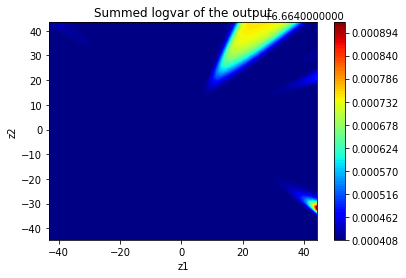

In [67]:
max_x = latent_means.max(dim=0).values[0]
max_y = latent_means.max(dim=0).values[1]
min_x = latent_means.min(dim=0).values[0]
min_y = latent_means.min(dim=0).values[1]

# plot the latent space
n=100
offset=40
x = torch.linspace(min_x-offset,max_x+offset,n)
y = torch.linspace(min_y-offset,max_y+offset,n)
X,Y = torch.meshgrid(x,y)
grid = torch.cat((X.reshape(-1,1),Y.reshape(-1,1)),dim=1)

with torch.no_grad():
    logvar_x = model.decode(grid)[1]
    summed_logvar_x = torch.log(torch.sum(torch.exp(logvar_x/2),dim=1))
    #summed_logvar_x = torch.sum(logvar_x,dim=1)
    summed_logvar_x = summed_logvar_x.reshape(X.shape)
    plt.figure()
    plt.contourf(X,Y,summed_logvar_x,levels=100,cmap='jet')
    plt.colorbar()
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.title('Summed logvar of the output')
    plt.show()

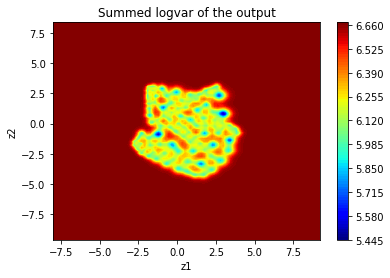

In [68]:
max_x = latent_means.max(dim=0).values[0]
max_y = latent_means.max(dim=0).values[1]
min_x = latent_means.min(dim=0).values[0]
min_y = latent_means.min(dim=0).values[1]

# plot the latent space
n=100
offset=5
x = torch.linspace(min_x-offset,max_x+offset,n)
y = torch.linspace(min_y-offset,max_y+offset,n)
X,Y = torch.meshgrid(x,y)
grid = torch.cat((X.reshape(-1,1),Y.reshape(-1,1)),dim=1)

with torch.no_grad():
    logvar_x = rbfnn(grid)
    summed_logvar_x = torch.log(torch.sum(1/torch.exp(logvar_x/2),dim=1))
    summed_logvar_x = summed_logvar_x.reshape(X.shape)
    plt.figure()
    plt.contourf(X,Y,summed_logvar_x,levels=100,cmap='jet')
    plt.colorbar()
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.title('Summed logvar of the output')
    plt.show()

# Save the trained models into a .pt

In [69]:
# combine both model into one torch module
vae_rbf_model = VAE_RBF.VAE_RBF(model,rbfnn)
torch.save(vae_rbf_model.state_dict(), 'torch_models/VAE_RBFNN_fashionmnist5classes.pt')